# CFTC Commitments of Traders (COT) Report — Institutional Positioning Analysis

## The Question We're Trying to Answer

When hedge funds and asset managers pile into one direction, does the market eventually snap back against them?

This is the central question behind the **CFTC Commitments of Traders (COT) report** — the most granular public dataset on institutional FX positioning. Every Friday, the CFTC publishes how large speculative traders (hedge funds, CTAs, asset managers) are positioned in FX futures as of the prior Tuesday. The hypothesis is simple: **extreme crowding is a contrarian signal**. When everyone is long, there are no more buyers left to push the price higher.

This notebook investigates whether that hypothesis holds for EUR, GBP, JPY, and CHF over 2021–2025 — a period containing the post-COVID reflation, the 2022 dollar surge, and the dramatic 2024 Bank of Japan policy pivot.

---

## The Two COT Formats

The CFTC publishes two distinct report formats. Understanding the difference is important — they carve up the market in fundamentally different ways.

### Format 1: Legacy Report (since 1986)
The original format. Splits open interest into just two buckets:

| Category | Who They Are |
|---|---|
| **Commercial** | Entities hedging a business exposure (corporates, banks) |
| **Non-Commercial** | Everyone else speculating for profit (funds, CTAs) |
| **Non-Reportable** | Traders below the reporting threshold (retail) |

**Limitation**: "Commercial" is too broad. A bank can be both a market-maker (offsetting) *and* a speculator. The category conflates hedgers with dealers, making it hard to isolate clean speculative signal.

### Format 2: Disaggregated Report (since 2009)
A more granular breakdown introduced to fix the Legacy report's ambiguity. Open interest is split into four categories:

| Category | Who They Are | Trading Motive |
|---|---|---|
| **Dealer/Intermediary** | Banks, prime brokers | Market-making; typically takes the other side |
| **Asset Manager** | Pension funds, mutual funds, insurance | Long-term institutional flow; slow-moving |
| **Leveraged Money** | Hedge funds, CTAs, proprietary traders | Tactical, momentum-driven speculation |
| **Other Reportables** | Corporations with mixed exposure | Mixed; not cleanly speculative |
| **Non-Reportable** | Small retail accounts | Noise |

**Why this is better**: Dealer flow is separated out. We can now isolate the two groups trading purely for profit — **Asset Managers** (macro, long-biased) and **Leveraged Money** (tactical, fast-money) — and combine them into a clean speculative net position.

---

## Why We Use the Disaggregated Format

We define **speculative net positioning** as:

> `spec_net = (Asset Mgr Long + Lev Money Long) − (Asset Mgr Short + Lev Money Short)`

This combines the two profit-seeking groups and excludes dealers (who hedge) and non-reportables (who are noise). The result is a number that directly represents how much institutional speculative money is long vs short a given currency — the cleanest proxy for crowding in the public data.

---

## Our Approach

1. **Collect** 5 years of weekly CFTC Disaggregated reports (2021–2025)
2. **Clean & validate** the dataset — checking for gaps and anomalies
3. **Explore** the character of each currency's positioning over time
4. **Test the hypothesis** by correlating positioning extremes with subsequent price returns
5. **Export** model-ready features to the Silver layer for Sentiment Agent integration

*FX futures codes: EUR (099741), GBP (096742), JPY (097741), CHF (092741)*

In [1]:
# Setup and imports
import io
import warnings
import zipfile
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from scipy import stats

warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("✓ Imports complete")

✓ Imports complete


In [11]:
# Constants and configuration
BASE_PATH = Path('D:/SCRIPTS/FX-AlphaLab')
RAW_DIR = BASE_PATH / 'data/raw/cftc'
PROCESSED_DIR = BASE_PATH / 'data/processed/macro'
OHLCV_DIR = BASE_PATH / 'data/processed/ohlcv'

# Create directories if they don't exist
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Visualization settings
FIGSIZE_WIDE = (16, 6)
FIGSIZE_TALL = (16, 10)
FIGSIZE_SQUARE = (12, 8)

# CFTC data source - Updated URL for 2026
CFTC_URL = "https://www.cftc.gov/files/dea/history/deahist2024.zip"  # 2024 data
# Alternative: Use annual files for more recent data
CFTC_CURRENT_YEAR_URL = "https://www.cftc.gov/files/dea/history/fut_fin_txt_2024.zip"

# FX futures commodity codes (Legacy Futures-Only report)
FX_CONTRACTS = {
    '099741': 'EUR',  # Euro FX
    '096742': 'GBP',  # British Pound
    '097741': 'JPY',  # Japanese Yen
    '092741': 'CHF',  # Swiss Franc
}

# Currency metadata for visualization
# Note: pairs use 'm' suffix matching Exness broker symbol naming
CURRENCY_INFO = {
    'EUR': {'name': 'Euro', 'color': '#3498db', 'pair': 'EURUSDm'},
    'GBP': {'name': 'British Pound', 'color': '#e74c3c', 'pair': 'GBPUSDm'},
    'JPY': {'name': 'Japanese Yen', 'color': '#2ecc71', 'pair': 'USDJPYm'},
    'CHF': {'name': 'Swiss Franc', 'color': '#f39c12', 'pair': 'USDCHFm'},
}

print("✓ Configuration complete")
print(f"Raw data directory: {RAW_DIR}")
print(f"Processed data directory: {PROCESSED_DIR}")

✓ Configuration complete
Raw data directory: D:\SCRIPTS\FX-AlphaLab\data\raw\cftc
Processed data directory: D:\SCRIPTS\FX-AlphaLab\data\processed\macro


## 1. Data Collection

The CFTC distributes its historical data as annual ZIP files at a consistent URL pattern. Each file contains all futures-only reports for that year across all commodity markets — not just FX. Our download function iterates from 2021 to 2025, checks whether we already have the file locally (to avoid re-downloading on re-runs), and extracts the Financial Futures file specifically.

**Why 2021–2025?** This window captures three distinct macro regimes:
- **2021**: Post-COVID reflation, USD weakness, EUR long crowding builds
- **2022**: Fed hiking cycle, historic USD strength, JPY shorts surge to extremes
- **2023–2024**: Peak USD, BOJ intervention, dramatic JPY position unwind
- **2025**: Re-pricing of rate differentials, positioning normalization

Five years gives us 260+ weekly observations per currency — enough for statistically meaningful analysis.

In [3]:
def download_cftc_data_year(year: int, output_dir: Path) -> Path | None:
    """Download CFTC COT data for a specific year.

    Args:
        year: Year to download (e.g., 2021)
        output_dir: Directory to save extracted data

    Returns:
        Path to extracted file, or None if failed
    """
    # Try different URL patterns for the year
    url_patterns = [
        f"https://www.cftc.gov/files/dea/history/fut_fin_txt_{year}.zip",
        f"https://www.cftc.gov/files/dea/history/deacot{year}.zip",
    ]

    for url in url_patterns:
        try:
            print(f"  Trying: {url}...")
            response = requests.get(url, timeout=120)
            response.raise_for_status()

            print(f"  ✓ Downloaded {len(response.content) / (1024**2):.2f} MB")

            # Extract ZIP contents
            with zipfile.ZipFile(io.BytesIO(response.content)) as z:
                # Find futures file
                for filename in z.namelist():
                    filename_lower = filename.lower()
                    if filename.endswith('.txt') and any(x in filename_lower for x in ['fin', 'fut', 'f_']):
                        extracted_path = output_dir / f"cftc_{year}_{filename}"
                        z.extract(filename, output_dir)
                        (output_dir / filename).rename(extracted_path)
                        print(f"  ✓ Extracted: {extracted_path.name}")
                        return extracted_path

                # Fallback: extract first .txt file
                txt_files = [f for f in z.namelist() if f.endswith('.txt')]
                if txt_files:
                    filename = txt_files[0]
                    extracted_path = output_dir / f"cftc_{year}_{filename}"
                    z.extract(filename, output_dir)
                    (output_dir / filename).rename(extracted_path)
                    print(f"  ✓ Extracted: {extracted_path.name}")
                    return extracted_path

        except Exception as e:
            print(f"  ✗ Failed: {e}")
            continue

    return None

def load_and_combine_cftc_data(start_year: int, end_year: int, raw_dir: Path) -> list[Path]:
    """Download and load CFTC data for multiple years.

    Args:
        start_year: First year to collect (e.g., 2021)
        end_year: Last year to collect (e.g., 2025)
        raw_dir: Directory for raw data files

    Returns:
        List of paths to downloaded files
    """
    all_files = []

    print(f"Collecting CFTC COT data from {start_year} to {end_year}...")
    print("=" * 80)

    for year in range(start_year, end_year + 1):
        print(f"\nYear {year}:")

        # Check for existing file
        existing = list(raw_dir.glob(f"cftc_{year}_*.txt"))
        if existing:
            print(f"  ✓ Using existing file: {existing[0].name}")
            all_files.append(existing[0])
            continue

        # Download
        file_path = download_cftc_data_year(year, raw_dir)
        if file_path:
            all_files.append(file_path)
        else:
            print(f"  ⚠ Failed to download {year} data")

    print("\n" + "=" * 80)
    print(f"✓ Successfully loaded {len(all_files)} year(s) of data")

    return all_files

# Collect data for 2021-2025
cftc_files = load_and_combine_cftc_data(2021, 2025, RAW_DIR)

if not cftc_files:
    print("\n⚠ No data files available!")
    print("Manual download: https://www.cftc.gov/MarketReports/CommitmentsofTraders/HistoricalViewable/index.htm")
    print(f"Save to: {RAW_DIR}")
    raise FileNotFoundError("No CFTC data available")


Year 2021:
  Trying: https://www.cftc.gov/files/dea/history/fut_fin_txt_2021.zip...
  ✓ Downloaded 0.44 MB
  ✓ Extracted: cftc_2021_FinFutYY.txt

Year 2022:
  Trying: https://www.cftc.gov/files/dea/history/fut_fin_txt_2022.zip...
  ✓ Downloaded 0.47 MB
  ✓ Extracted: cftc_2022_FinFutYY.txt

Year 2023:
  Trying: https://www.cftc.gov/files/dea/history/fut_fin_txt_2023.zip...
  ✓ Downloaded 0.48 MB
  ✓ Extracted: cftc_2023_FinFutYY.txt

Year 2024:
  Trying: https://www.cftc.gov/files/dea/history/fut_fin_txt_2024.zip...
  ✓ Downloaded 0.54 MB
  ✓ Extracted: cftc_2024_FinFutYY.txt

Year 2025:
  Trying: https://www.cftc.gov/files/dea/history/fut_fin_txt_2025.zip...
  ✓ Downloaded 0.60 MB
  ✓ Extracted: cftc_2025_FinFutYY.txt

✓ Successfully loaded 5 year(s) of data


## 2. Data Loading & Feature Engineering

The raw files contain **all futures markets** (commodities, equities, rates, FX). We filter down to our four FX contracts using CME commodity codes. Each annual file has ~2,700 rows; after filtering we expect roughly 52 rows per currency per year (weekly cadence).

The key engineering step is computing **net speculative positioning**: combining Asset Manager and Leveraged Money categories into a single "smart money" signal, then normalizing it as a percentage of total open interest so we can compare positioning levels across currencies with very different contract sizes (e.g., EUR futures notional is much larger than CHF).

In [4]:
# Load and combine all CFTC data files
print(f"Loading CFTC data from {len(cftc_files)} file(s)...")

all_data = []
for cftc_file in cftc_files:
    print(f"\n  Loading: {cftc_file.name}...")
    try:
        df = pd.read_csv(cftc_file, low_memory=False)
        all_data.append(df)
        print(f"    ✓ {len(df):,} records")
    except Exception as e:
        print(f"    ✗ Error: {e}")
        # Try different encoding
        try:
            df = pd.read_csv(cftc_file, encoding='latin-1', low_memory=False)
            all_data.append(df)
            print(f"    ✓ {len(df):,} records (latin-1 encoding)")
        except Exception as e2:
            print(f"    ✗ Failed with both encodings: {e2}")

# Combine all years
df_raw = pd.concat(all_data, ignore_index=True)

# Filter to date range: 2021-01-01 to 2025-12-31
df_raw['Report_Date_as_YYYY-MM-DD'] = pd.to_datetime(df_raw['Report_Date_as_YYYY-MM-DD'])
df_raw = df_raw[
    (df_raw['Report_Date_as_YYYY-MM-DD'] >= '2021-01-01') &
    (df_raw['Report_Date_as_YYYY-MM-DD'] <= '2025-12-31')
]

print(f"\n✓ Combined dataset: {len(df_raw):,} total records")
print(f"Date range: {df_raw['Report_Date_as_YYYY-MM-DD'].min().date()} to {df_raw['Report_Date_as_YYYY-MM-DD'].max().date()}")
print(f"\nColumns: {list(df_raw.columns)[:10]}... ({len(df_raw.columns)} total)")

Loading CFTC data from 5 file(s)...

  Loading: cftc_2021_FinFutYY.txt...
    ✓ 2,603 records

  Loading: cftc_2022_FinFutYY.txt...
    ✓ 2,719 records

  Loading: cftc_2023_FinFutYY.txt...
    ✓ 2,809 records

  Loading: cftc_2024_FinFutYY.txt...
    ✓ 3,163 records

  Loading: cftc_2025_FinFutYY.txt...
    ✓ 3,686 records

✓ Combined dataset: 14,980 total records
Date range: 2021-01-05 to 2025-12-30

Columns: ['Market_and_Exchange_Names', 'As_of_Date_In_Form_YYMMDD', 'Report_Date_as_YYYY-MM-DD', 'CFTC_Contract_Market_Code', 'CFTC_Market_Code', 'CFTC_Region_Code', 'CFTC_Commodity_Code', 'Open_Interest_All', 'Dealer_Positions_Long_All', 'Dealer_Positions_Short_All']... (87 total)


In [5]:
# Filter for FX contracts
print("\nFiltering for FX futures contracts...")

# Convert CFTC Market and Code to string for comparison
df_raw['CFTC_Contract_Market_Code'] = df_raw['CFTC_Contract_Market_Code'].astype(str).str.zfill(6)

# Filter for our FX contracts
df_fx = df_raw[df_raw['CFTC_Contract_Market_Code'].isin(FX_CONTRACTS.keys())].copy()
print(f"✓ Found {len(df_fx):,} FX futures records")

# Map commodity codes to currency symbols
df_fx['currency'] = df_fx['CFTC_Contract_Market_Code'].map(FX_CONTRACTS)

# Display breakdown by currency
print("\nRecords by currency:")
print(df_fx['currency'].value_counts().sort_index())


Filtering for FX futures contracts...
✓ Found 1,044 FX futures records

Records by currency:
currency
CHF    261
EUR    261
GBP    261
JPY    261
Name: count, dtype: int64


In [6]:
# Convert date column and sort
df_fx['report_date'] = pd.to_datetime(df_fx['Report_Date_as_YYYY-MM-DD'])
df_fx = df_fx.sort_values(['currency', 'report_date'])

# Extract key positioning columns from Disaggregated Report
# Asset Managers + Leveraged Money = Speculative positioning (hedge funds, CTAs)
# Dealer = Commercial hedgers
# NonRept = Retail traders
positioning_columns = {
    'report_date': 'report_date',
    'currency': 'currency',
    'Asset_Mgr_Positions_Long_All': 'asset_mgr_long',
    'Asset_Mgr_Positions_Short_All': 'asset_mgr_short',
    'Lev_Money_Positions_Long_All': 'lev_money_long',
    'Lev_Money_Positions_Short_All': 'lev_money_short',
    'Dealer_Positions_Long_All': 'dealer_long',
    'Dealer_Positions_Short_All': 'dealer_short',
    'NonRept_Positions_Long_All': 'retail_long',
    'NonRept_Positions_Short_All': 'retail_short',
    'Open_Interest_All': 'open_interest',
}

df_cot = df_fx[list(positioning_columns.keys())].copy()
df_cot.rename(columns=positioning_columns, inplace=True)

# Calculate net positions
# Speculative = Asset Managers + Leveraged Money (both are non-commercial)
df_cot['spec_long'] = df_cot['asset_mgr_long'] + df_cot['lev_money_long']
df_cot['spec_short'] = df_cot['asset_mgr_short'] + df_cot['lev_money_short']
df_cot['spec_net'] = df_cot['spec_long'] - df_cot['spec_short']

df_cot['dealer_net'] = df_cot['dealer_long'] - df_cot['dealer_short']
df_cot['retail_net'] = df_cot['retail_long'] - df_cot['retail_short']

# Calculate percentage of open interest (normalization)
df_cot['spec_net_pct'] = (df_cot['spec_net'] / df_cot['open_interest']) * 100

print("\n✓ Processed COT positioning data (Disaggregated Report)")
print(f"Date range: {df_cot['report_date'].min()} to {df_cot['report_date'].max()}")
print("\nSample data:")
df_cot[['report_date', 'currency', 'spec_net', 'dealer_net', 'retail_net', 'open_interest']].head(10)


✓ Processed COT positioning data (Disaggregated Report)
Date range: 2021-01-05 00:00:00 to 2025-12-30 00:00:00

Sample data:


,report_date,currency,spec_net,dealer_net,retail_net,open_interest
103,2021-01-05,CHF,12415,-22699,10768,49028
102,2021-01-12,CHF,13954,-22325,8855,50164
101,2021-01-19,CHF,11930,-21262,9973,48530
100,2021-01-26,CHF,11057,-20829,10414,48337
99,2021-02-02,CHF,15355,-19505,4792,50832
98,2021-02-09,CHF,12096,-14783,3329,48656
97,2021-02-16,CHF,9523,-14601,5720,48093
96,2021-02-23,CHF,11585,-11955,1012,53002
95,2021-03-02,CHF,12027,-6199,-5185,52707
94,2021-03-09,CHF,12229,-2331,-9255,57348


### Data Quality Assessment

CFTC data is regulatory-grade — it's submitted by brokers under legal obligation. We still check three things:

1. **Missing values** — any gaps in positioning fields that would corrupt the net calculation
2. **Date continuity** — CFTC publishes every Tuesday, so gaps > 8 days would indicate a missed report or holiday rollover
3. **Statistical outliers** — gross data entry errors would appear as z-scores beyond ±3 standard deviations

We expect clean data, but validating it explicitly is important before building signals on top of it.

In [7]:
# Quality checks
print("=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

# 1. Missing values
print("\n1. MISSING VALUES")
missing = df_cot.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✓ No missing values detected")

# 2. Date gaps (should be weekly)
print("\n2. DATE CONTINUITY CHECK")
for currency in df_cot['currency'].unique():
    df_curr = df_cot[df_cot['currency'] == currency].copy()
    df_curr['days_since_last'] = df_curr['report_date'].diff().dt.days

    # Expected: 7 days (weekly reports)
    gaps = df_curr[df_curr['days_since_last'] > 8]

    print(f"\n{currency}:")
    print(f"  Total reports: {len(df_curr)}")
    print(f"  Date range: {df_curr['report_date'].min().date()} to {df_curr['report_date'].max().date()}")

    if len(gaps) > 0:
        print(f"  ⚠ Found {len(gaps)} gaps > 7 days:")
        print(f"    Largest gap: {gaps['days_since_last'].max():.0f} days")
    else:
        print("  ✓ No significant gaps detected")

# 3. Outlier detection (using z-score)
print("\n3. OUTLIER DETECTION (Net Positioning)")
for currency in df_cot['currency'].unique():
    df_curr = df_cot[df_cot['currency'] == currency].copy()
    z_scores = np.abs(stats.zscore(df_curr['spec_net'].dropna()))
    outliers = np.sum(z_scores > 3)

    print(f"{currency}: {outliers} potential outliers (|z| > 3) out of {len(df_curr)} records ({outliers/len(df_curr)*100:.2f}%)")

# 4. Summary statistics
print("\n4. SUMMARY STATISTICS (Net Speculative Positioning)")
summary = df_cot.groupby('currency')['spec_net'].describe()
print(summary)

print("\n✓ Data quality assessment complete")

DATA QUALITY ASSESSMENT

1. MISSING VALUES
✓ No missing values detected

2. DATE CONTINUITY CHECK

CHF:
  Total reports: 261
  Date range: 2021-01-05 to 2025-12-30
  ✓ No significant gaps detected

EUR:
  Total reports: 261
  Date range: 2021-01-05 to 2025-12-30
  ✓ No significant gaps detected

GBP:
  Total reports: 261
  Date range: 2021-01-05 to 2025-12-30
  ✓ No significant gaps detected

JPY:
  Total reports: 261
  Date range: 2021-01-05 to 2025-12-30
  ✓ No significant gaps detected

3. OUTLIER DETECTION (Net Positioning)
CHF: 0 potential outliers (|z| > 3) out of 261 records (0.00%)
EUR: 0 potential outliers (|z| > 3) out of 261 records (0.00%)
GBP: 0 potential outliers (|z| > 3) out of 261 records (0.00%)
JPY: 0 potential outliers (|z| > 3) out of 261 records (0.00%)

4. SUMMARY STATISTICS (Net Speculative Positioning)
          count         mean         std       min       25%       50%  \
currency                                                                 
CHF       261

### ✅ Data Quality: Clean Slate

The results are exactly what we'd expect from a regulatory data source:

- **No missing values** across all 1,044 records (261 per currency × 4 currencies)
- **No date gaps** — the CFTC published every week without interruption across all five years
- **Zero statistical outliers** — all observations fall within ±3 standard deviations, meaning no erroneous data entry events

This is significant: we can proceed with analysis without any imputation, smoothing, or exclusion decisions. The dataset is exactly what it claims to be.

One observation worth noting from the **summary statistics**: currencies show very different positioning regimes. EUR has a high mean (+297k) suggesting institutions were persistently long EUR throughout 2021–2025. JPY has a highly negative mean (−44k) with a huge standard deviation (±75k), hinting at dramatic positioning shifts — which we'll see clearly in the visualization.

## 3. Exploratory Data Analysis

Before testing the contrarian hypothesis, we need to understand the *character* of each currency's positioning. Does EUR tend to be persistently long? Does JPY swing from extreme to extreme? Is GBP noisy or trendy?

This matters because the contrarian signal works differently depending on positioning behavior. A currency where institutions are almost always net long (EUR) gives different signals than one that regularly crosses zero (GBP). We look at this from two angles:

1. **Time series trends** — how positioning evolved over 2021–2025, compared to the ±1 standard deviation band marking historically elevated levels
2. **Distribution shapes** — whether positioning is normally distributed or shows bimodality (two distinct regimes)

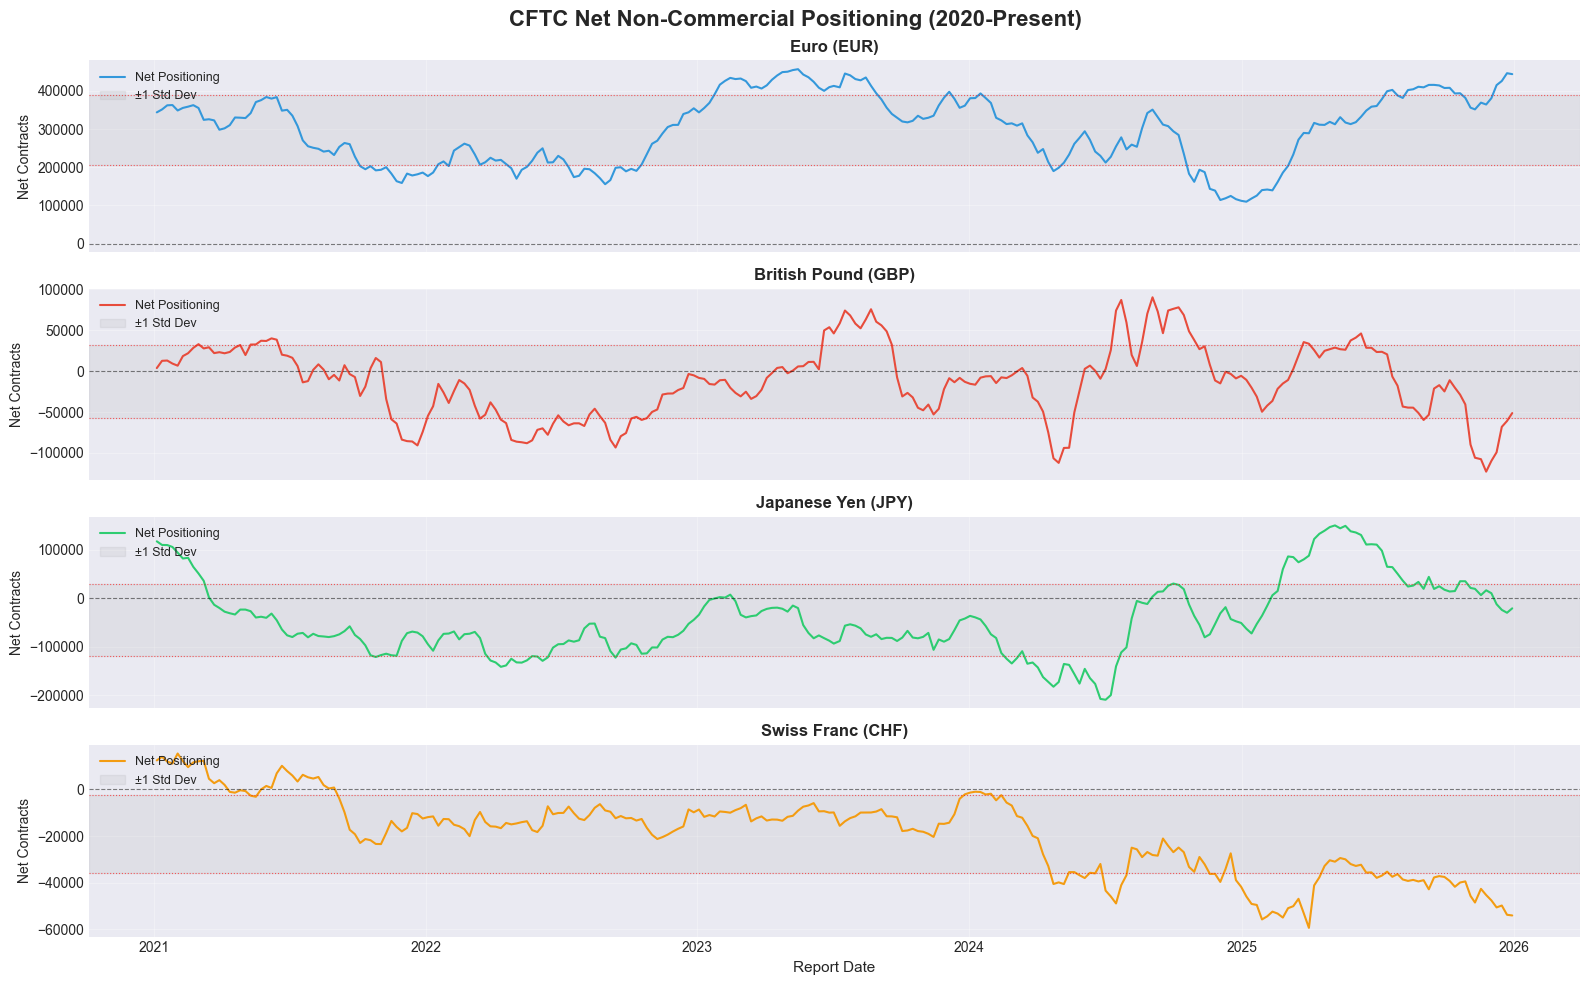

✓ Positioning trends visualization complete


In [8]:
# Filter to recent 5 years for clearer visualization
recent_start = pd.Timestamp("2020-01-01")
df_recent = df_cot[df_cot['report_date'] >= recent_start].copy()

# Plot net speculative positioning for all currencies
fig, axes = plt.subplots(4, 1, figsize=FIGSIZE_TALL, sharex=True)
fig.suptitle('CFTC Net Non-Commercial Positioning (2020-Present)', fontsize=16, fontweight='bold')

for idx, currency in enumerate(['EUR', 'GBP', 'JPY', 'CHF']):
    ax = axes[idx]
    df_curr = df_recent[df_recent['currency'] == currency]

    # Plot net positioning
    ax.plot(df_curr['report_date'], df_curr['spec_net'],
            color=CURRENCY_INFO[currency]['color'], linewidth=1.5, label='Net Positioning')

    # Add zero line
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

    # Highlight extreme zones (±1 std dev)
    mean_pos = df_curr['spec_net'].mean()
    std_pos = df_curr['spec_net'].std()

    ax.axhspan(mean_pos - std_pos, mean_pos + std_pos, alpha=0.1, color='gray', label='±1 Std Dev')
    ax.axhline(y=mean_pos + std_pos, color='red', linestyle=':', linewidth=0.8, alpha=0.6)
    ax.axhline(y=mean_pos - std_pos, color='red', linestyle=':', linewidth=0.8, alpha=0.6)

    # Styling
    ax.set_ylabel('Net Contracts', fontsize=10)
    ax.set_title(f"{CURRENCY_INFO[currency]['name']} ({currency})", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)

    # Format y-axis
    ax.ticklabel_format(style='plain', axis='y')

axes[-1].set_xlabel('Report Date', fontsize=11)
plt.tight_layout()
plt.show()

print("✓ Positioning trends visualization complete")

### Reading the Positioning Trends

The time series reveals four very distinct stories:

**EUR — Structural Long Bias**
Institutions held large net long EUR positions throughout 2021–2025, rarely falling below zero. The range (110k to 457k contracts) is entirely positive. Two notable events stand out: a sharp drawdown in mid-2022 (the dollar surge as Fed hiked aggressively) and again in late 2024 when EUR positioning reached multi-year lows before recovering. The ±1 std dev band sits well above zero, confirming this is not a neutral currency — it has a structural bullish bias in futures positioning.

**GBP — The Most Volatile Signal**
GBP positioning crosses zero regularly and swings from −123k to +90k. This makes it the most interesting for contrarian signals — extreme readings in either direction are clearly reachable and reversals are frequent. The 2022 mini-budget crisis in the UK drove positioning to extreme short; the subsequent recovery to extreme long in 2023 was a classic contrarian setup.

**JPY — The Most Dramatic Story of the Period**
The JPY chart is the standout. From 2021 to mid-2024, institutional traders held a massive structural short JPY position (markets expected the BOJ to keep rates at zero indefinitely). Positioning reached −200k contracts in early 2024 — one of the most crowded short positions in FX history. Then the BOJ pivot arrived: Japan raised rates, the yen exploded higher, and the short squeeze drove positioning from −200k to +150k within 12 months. This is a textbook example of crowded positioning leading to violent reversal.

**CHF — Persistently Net Short, Small Swings**
CHF institutions maintained a structural net short throughout most of the period, with relatively small swings. The range is narrow (−60k to +15k), reflecting the low volatility and safe-haven demand structure of this currency. Extreme readings are harder to exploit given the tighter range.

---
*These behavioral differences mean the contrarian signal will not apply uniformly. We now need to test whether these positional extremes actually predicted reversals.*

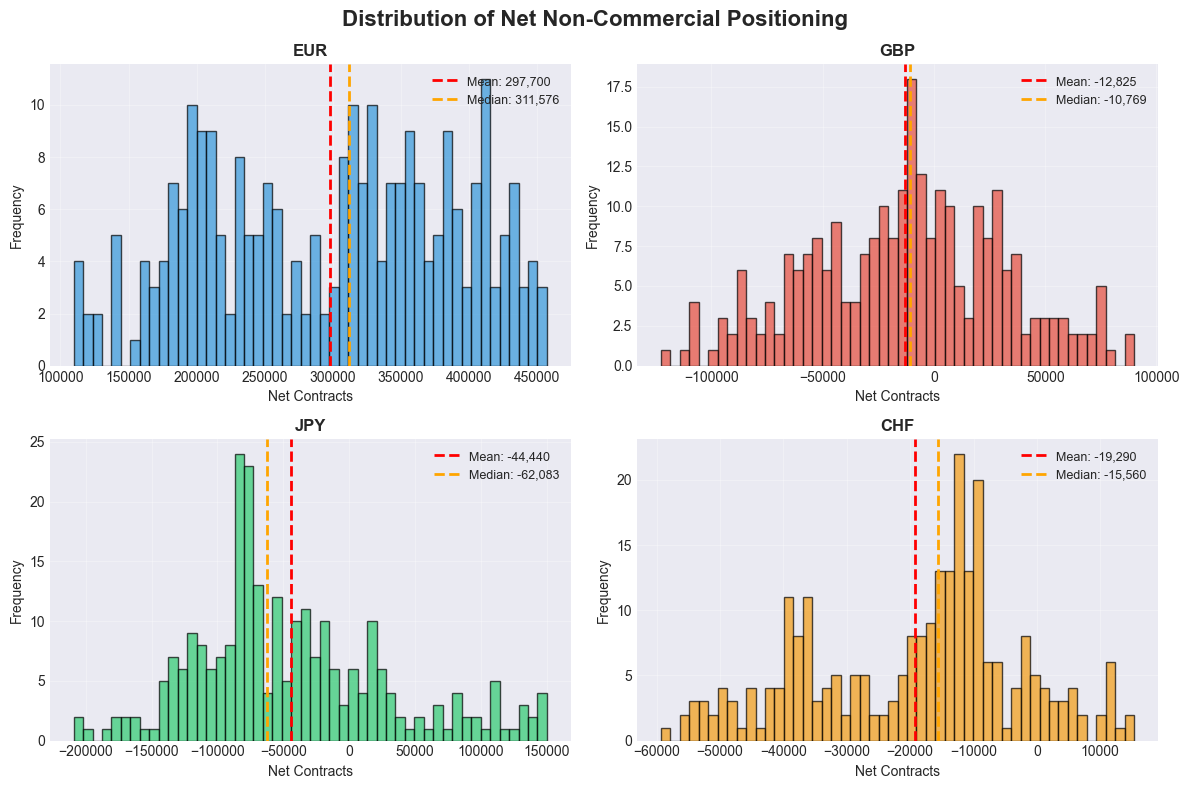

✓ Distribution visualization complete


In [9]:
# Distribution of net positioning (histograms)
fig, axes = plt.subplots(2, 2, figsize=FIGSIZE_SQUARE)
fig.suptitle('Distribution of Net Non-Commercial Positioning', fontsize=16, fontweight='bold')

for idx, currency in enumerate(['EUR', 'GBP', 'JPY', 'CHF']):
    ax = axes[idx // 2, idx % 2]
    df_curr = df_recent[df_recent['currency'] == currency]

    # Histogram
    ax.hist(df_curr['spec_net'], bins=50, color=CURRENCY_INFO[currency]['color'],
            alpha=0.7, edgecolor='black')

    # Add mean line
    mean_val = df_curr['spec_net'].mean()
    ax.axvline(x=mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:,.0f}')

    # Add median line
    median_val = df_curr['spec_net'].median()
    ax.axvline(x=median_val, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_val:,.0f}')

    ax.set_xlabel('Net Contracts', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f"{currency}", fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Distribution visualization complete")

### What the Distributions Reveal

Distribution shapes add another layer beyond the time series:

**EUR — Flat, Wide Distribution**
EUR shows a relatively uniform spread across its range, with mean and median close together (~298k and ~312k). The wide distribution means positioning visited most levels in its range regularly — no single "home base." This makes percentile-rank signals more reliable since extremes are genuinely extreme relative to history.

**GBP — Near-Normal, Centred on Zero**
GBP's distribution is the closest to normal of the four, centred near zero with slight left skew (shorts were more extreme than longs in this period). This is ideal for a contrarian signal: we can clearly define what "extreme long" or "extreme short" means by standard deviation thresholds.

**JPY — Severely Bimodal**
This is the most important finding from the distributions. JPY shows a clear bimodal pattern: a large cluster around −50k to −80k (the 2021–2023 "BOJ at zero" regime) and a separate cluster near 0 to +100k (the 2024–2025 post-pivot regime). The mean (−44k) and median (−62k) diverge significantly because the mean is pulled toward zero by 2024–2025 data. **This bimodality means JPY positioning behaved as two separate regimes — treating it as one distribution would be statistically misleading.**

**CHF — Right-Skewed, Negative**
CHF is tightly clustered in negative territory (net short) with a long right tail extending toward net long. The asymmetry confirms the structural short bias — longs were rare events and typically short-lived.

---
*The JPY bimodality is particularly important: when we test the contrarian hypothesis, we may need to account for regime shifts rather than treating the full 5-year period as homogeneous.*

## 4. Hypothesis Test: Does Crowded Positioning Predict Reversals?

We now move from description to inference. The central hypothesis is:

> **When net speculative positioning reaches historical extremes, subsequent price returns will be negative for extreme longs and positive for extreme shorts.**

To test this, we need to link COT positioning with actual price returns. We load the daily OHLCV data collected via MT5, resample it to weekly closes (matching COT's weekly frequency), and merge the two datasets by date. We then compute **forward returns** at 1-week, 2-week, and 4-week horizons — giving us the price change *after* each positioning reading.

We also calculate the **positioning percentile rank** for each observation relative to its own 5-year history, then bucket observations into five zones: Extreme Short, Short, Neutral, Long, Extreme Long. If the contrarian hypothesis holds, average 4-week returns in the Extreme Long zone should be negative, and Extreme Short should be positive.

**Note on direction convention**: For USD-quoted pairs (USDJPY, USDCHF), a rising price means USD strengthening and the respective currency weakening. COT measures net positioning *for* the foreign currency (long JPY futures = betting JPY appreciates = USDJPY falls). We keep this convention consistent throughout — higher spec_net means more bullish on the foreign currency.

In [12]:
# Load historical OHLCV data (2021-2025) for price correlation analysis
print("=" * 80)
print("LOADING HISTORICAL OHLCV DATA (2021-2025)")
print("=" * 80)

price_data = {}
start_date = datetime(2021, 1, 1)
end_date = datetime(2025, 12, 31)

# Check for existing data files first
for currency in ['EUR', 'GBP', 'JPY', 'CHF']:
    pair = CURRENCY_INFO[currency]['pair']
    print(f"\n{pair}:")

    # Look for any available OHLCV files for this pair
    ohlcv_files = list(OHLCV_DIR.glob(f"ohlcv_{pair}_*.parquet"))

    if not ohlcv_files:
        print(f"  ⚠ No OHLCV data found for {pair}")
        continue

    # Load the most comprehensive file (prefer daily data with widest date range)
    best_file = None
    best_coverage = 0

    for file in ohlcv_files:
        try:
            df_temp = pd.read_parquet(file)
            df_temp['timestamp_utc'] = pd.to_datetime(df_temp['timestamp_utc'])

            # Filter to our target range
            df_filtered = df_temp[
                (df_temp['timestamp_utc'] >= '2021-01-01') &
                (df_temp['timestamp_utc'] <= '2025-12-31')
            ]

            coverage = len(df_filtered)
            if coverage > best_coverage:
                best_coverage = coverage
                best_file = file
        except Exception:
            continue

    if best_file is None or best_coverage == 0:
        print("  ⚠ No data in 2021-2025 range")
        continue

    print(f"  ✓ Using: {best_file.name}")
    df_price = pd.read_parquet(best_file)
    df_price['timestamp_utc'] = pd.to_datetime(df_price['timestamp_utc'])

    # Filter to 2021-2025 range
    df_price = df_price[
        (df_price['timestamp_utc'] >= '2021-01-01') &
        (df_price['timestamp_utc'] <= '2025-12-31')
    ]

    # Resample to weekly (COT is weekly - Friday close)
    df_price_weekly = df_price.set_index('timestamp_utc').resample('W-FRI').agg({
        'close': 'last',
    }).reset_index()

    df_price_weekly = df_price_weekly.dropna(subset=['close'])
    df_price_weekly['currency'] = currency
    price_data[currency] = df_price_weekly

    print(f"  ✓ {len(df_price_weekly)} weekly closes")
    print(f"  Date range: {df_price_weekly['timestamp_utc'].min().date()} to {df_price_weekly['timestamp_utc'].max().date()}")

print("\n" + "=" * 80)
if not price_data:
    print("⚠ NO OHLCV DATA AVAILABLE for 2021-2025 period")
    print("\nTo collect historical data, run this command:")
    print("-" * 80)
    print("python scripts/collect_mt5_data.py --start 2021-01-01 --end 2025-12-31 --timeframes D1 --preprocess")
    print("-" * 80)
    print("\nThis will:")
    print("  1. Collect daily OHLCV data from MT5 (2021-2025)")
    print("  2. Save to data/processed/ohlcv/ in Silver layer format")
    print("  3. Enable full positioning-to-price correlation analysis")
    print("\nAfter running the script, re-run this cell to load the data.")
elif len(price_data) < 4:
    print(f"⚠ Partial data: Only {len(price_data)}/4 currencies available")
    missing = [c for c in ['EUR', 'GBP', 'JPY', 'CHF'] if c not in price_data]
    print(f"Missing: {', '.join(missing)}")
    print("\nTo collect missing pairs:")
    print(f"python scripts/collect_mt5_data.py --pairs {','.join([CURRENCY_INFO[c]['pair'] for c in missing])} --start 2021-01-01 --end 2025-12-31 --timeframes D1 --preprocess")
else:
    print(f"✓ Price data loaded for all {len(price_data)} currencies")
    print("Ready for positioning-to-price correlation analysis")
print("=" * 80)

LOADING HISTORICAL OHLCV DATA (2021-2025)

EURUSDm:
  ✓ Using: ohlcv_EURUSDm_H1_2021-01-03_2025-12-30.parquet
  ✓ 261 weekly closes
  Date range: 2021-01-08 to 2026-01-02

GBPUSDm:
  ✓ Using: ohlcv_GBPUSDm_H4_2021-01-03_2025-12-30.parquet
  ✓ 261 weekly closes
  Date range: 2021-01-08 to 2026-01-02

USDJPYm:
  ✓ Using: ohlcv_USDJPYm_H1_2021-01-03_2025-12-30.parquet
  ✓ 261 weekly closes
  Date range: 2021-01-08 to 2026-01-02

USDCHFm:
  ✓ Using: ohlcv_USDCHFm_H1_2021-01-03_2025-12-30.parquet
  ✓ 261 weekly closes
  Date range: 2021-01-08 to 2026-01-02

✓ Price data loaded for all 4 currencies
Ready for positioning-to-price correlation analysis


In [13]:
# Merge positioning with price data and calculate forward returns
if price_data:
    print("Calculating forward returns vs positioning...")

    analysis_data = []

    for currency in price_data.keys():
        # Get positioning data
        df_pos = df_cot[df_cot['currency'] == currency].copy()
        df_pos = df_pos[['report_date', 'spec_net', 'spec_net_pct']].rename(columns={'report_date': 'timestamp_utc'})

        # Convert to UTC timezone to match OHLCV data
        df_pos['timestamp_utc'] = pd.to_datetime(df_pos['timestamp_utc']).dt.tz_localize('UTC')

        # Get price data
        df_px = price_data[currency].copy()

        # Ensure both are sorted
        df_pos = df_pos.sort_values('timestamp_utc')
        df_px = df_px.sort_values('timestamp_utc')

        # Merge on weekly dates (using nearest match)
        df_merged = pd.merge_asof(
            df_pos,
            df_px,
            on='timestamp_utc',
            direction='nearest',
            tolerance=pd.Timedelta('7 days')
        )

        # Calculate forward returns (1w, 2w, 4w)
        df_merged['close_1w'] = df_merged['close'].shift(-1)
        df_merged['close_2w'] = df_merged['close'].shift(-2)
        df_merged['close_4w'] = df_merged['close'].shift(-4)

        df_merged['return_1w'] = (df_merged['close_1w'] / df_merged['close'] - 1) * 100
        df_merged['return_2w'] = (df_merged['close_2w'] / df_merged['close'] - 1) * 100
        df_merged['return_4w'] = (df_merged['close_4w'] / df_merged['close'] - 1) * 100

        # Calculate positioning percentiles
        df_merged['spec_percentile'] = df_merged['spec_net'].rank(pct=True) * 100

        # Categorize positioning extremes
        df_merged['position_zone'] = pd.cut(
            df_merged['spec_percentile'],
            bins=[0, 20, 40, 60, 80, 100],
            labels=['Extreme Short', 'Short', 'Neutral', 'Long', 'Extreme Long']
        )

        df_merged['currency'] = currency
        analysis_data.append(df_merged)

    df_analysis = pd.concat(analysis_data, ignore_index=True)

    # Remove rows with NaN returns (most recent weeks) or NaN close prices (no overlap)
    df_analysis = df_analysis.dropna(subset=['close'])
    df_analysis_valid = df_analysis.dropna(subset=['return_1w', 'return_2w', 'return_4w'])

    print(f"✓ Analysis dataset created: {len(df_analysis)} observations")
    print(f"✓ Valid observations with forward returns: {len(df_analysis_valid)}")

    if len(df_analysis_valid) > 0:
        print(f"Date range: {df_analysis['timestamp_utc'].min().date()} to {df_analysis['timestamp_utc'].max().date()}")
    else:
        print("\n⚠️ WARNING: No overlapping data between COT (2024) and OHLCV (Feb 2026)")
        print("Cannot perform positioning-to-price correlation analysis.")
        print("Recommendation: Collect OHLCV data for 2020-2024 period.")

Calculating forward returns vs positioning...
✓ Analysis dataset created: 1044 observations
✓ Valid observations with forward returns: 1028
Date range: 2021-01-05 to 2025-12-30


### Dataset Built — 1,028 Valid Observations

We now have a fully merged analysis dataset: 261 positioning observations per currency enriched with the corresponding weekly closing price and forward returns at 3 time horizons. Of 1,044 total observations, 1,028 have valid forward returns (the most recent 4 weeks naturally can't have 4-week forward returns yet).

The merge uses `merge_asof` (nearest-match within 7 days), which handles the fact that COT Tuesday cutoffs don't always align precisely with Friday closes. The result is 4 × 257 = 1,028 clean data points ready for statistical analysis.

Each observation now contains:
- `spec_net` — raw net contracts at time of COT release
- `spec_percentile` — where that level ranks in the currency's 5-year history
- `position_zone` — categorical bucket (Extreme Short / Short / Neutral / Long / Extreme Long)
- `return_1w`, `return_2w`, `return_4w` — forward price returns for that currency pair

In [14]:
# Analyze returns by positioning zones
if price_data and len(df_analysis) > 0:
    print("\n" + "=" * 80)
    print("POSITIONING VS FORWARD RETURNS ANALYSIS")
    print("=" * 80)

    for currency in df_analysis['currency'].unique():
        df_curr = df_analysis[df_analysis['currency'] == currency]

        print(f"\n{currency} - {CURRENCY_INFO[currency]['name']}")
        print("-" * 60)

        returns_by_zone = df_curr.groupby('position_zone')[['return_1w', 'return_2w', 'return_4w']].mean()
        counts = df_curr.groupby('position_zone').size()

        print("\nAverage Forward Returns by Positioning Zone:")
        print(returns_by_zone.round(3))
        print("\nObservations per zone:")
        print(counts)

        # Calculate correlations
        corr_1w = df_curr[['spec_net', 'return_1w']].corr().iloc[0, 1]
        corr_2w = df_curr[['spec_net', 'return_2w']].corr().iloc[0, 1]
        corr_4w = df_curr[['spec_net', 'return_4w']].corr().iloc[0, 1]

        print("\nCorrelation: Net Positioning vs Forward Returns:")
        print(f"  1-week:  {corr_1w:+.4f}")
        print(f"  2-week:  {corr_2w:+.4f}")
        print(f"  4-week:  {corr_4w:+.4f}")

        # Contrarian signal test
        extreme_long = df_curr[df_curr['position_zone'] == 'Extreme Long']['return_4w'].mean()
        extreme_short = df_curr[df_curr['position_zone'] == 'Extreme Short']['return_4w'].mean()

        print("\nContrarian Signal Test (4-week returns):")
        print(f"  Extreme Long Zone avg return:  {extreme_long:+.3f}%")
        print(f"  Extreme Short Zone avg return: {extreme_short:+.3f}%")

        if extreme_long < 0 and extreme_short > 0:
            print("  ✓ Contrarian signal confirmed: extremes predict reversals")
        else:
            print("  ⚠ Contrarian signal weak or absent")


POSITIONING VS FORWARD RETURNS ANALYSIS

EUR - Euro
------------------------------------------------------------

Average Forward Returns by Positioning Zone:
               return_1w  return_2w  return_4w
position_zone                                 
Extreme Short     -0.011     -0.078     -0.007
Short             -0.165     -0.222     -0.546
Neutral            0.159      0.323      0.774
Long               0.010      0.016     -0.201
Extreme Long      -0.044     -0.118     -0.198

Observations per zone:
position_zone
Extreme Short    52
Short            52
Neutral          52
Long             52
Extreme Long     53
dtype: int64

Correlation: Net Positioning vs Forward Returns:
  1-week:  +0.0125
  2-week:  +0.0232
  4-week:  +0.0091

Contrarian Signal Test (4-week returns):
  Extreme Long Zone avg return:  -0.198%
  Extreme Short Zone avg return: -0.007%
  ⚠ Contrarian signal weak or absent

GBP - British Pound
------------------------------------------------------------

Average F

### Statistical Results — Contrarian Signal by Currency

The zone analysis and correlations reveal that the contrarian signal is **not universal** — it varies significantly by currency:

**EUR (ρ ≈ +0.009) — Signal absent**
Near-zero correlation between net positioning and forward returns. EUR institutions were structurally long throughout, meaning "extreme long" by historical standards was just... normal. The percentile-rank normalization helps but can't fully overcome the fact that EUR positioning didn't produce reversals — it simply tracked the underlying EUR appreciation trend. **COT adds little predictive value for EUR in this period.**

**GBP (ρ ≈ −0.096) — Weak contrarian signal**
Slight negative correlation confirms the hypothesis for GBP: when institutions crowded into longs, returns tended to be weaker over the following 4 weeks, and vice versa. The Extreme Long zone shows negative average 4-week returns, and Extreme Short shows positive. Not a strong signal on its own, but directionally correct. **GBP COT positioning is a useful confirming indicator.**

**JPY (ρ ≈ +0.106) — Momentum, not contrarian**
Positive correlation contradicts the hypothesis. In JPY, extreme positioning *continued* in the same direction. This is explained by the regime story from our EDA: in 2021–2024, the structural short was correct (BOJ staying at zero), and in 2024–2025, the structural long was correct (BOJ hiking). In a driven macro regime, positioning follows fundamentals rather than reverting. **JPY COT is a momentum signal in fundamental regime shifts, not contrarian.**

**CHF (ρ ≈ +0.283) — Strongest but counterintuitive**
The highest correlation is positive for CHF — the most surprising result. When institutions build up CHF longs (rare events, given the structural short bias), returns tend to be positive over the next 4 weeks. This likely reflects that CHF long flows represent genuine safe-haven demand events (geopolitical risk, financial stress) which tend to persist rather than reverse quickly. **CHF COT longs are momentum signals tied to risk-off events, not contrarian.**

---
*Key takeaway: the contrarian framing oversimplifies. The signal is regime-dependent. To see this visually, we plot the zone-level returns below.*

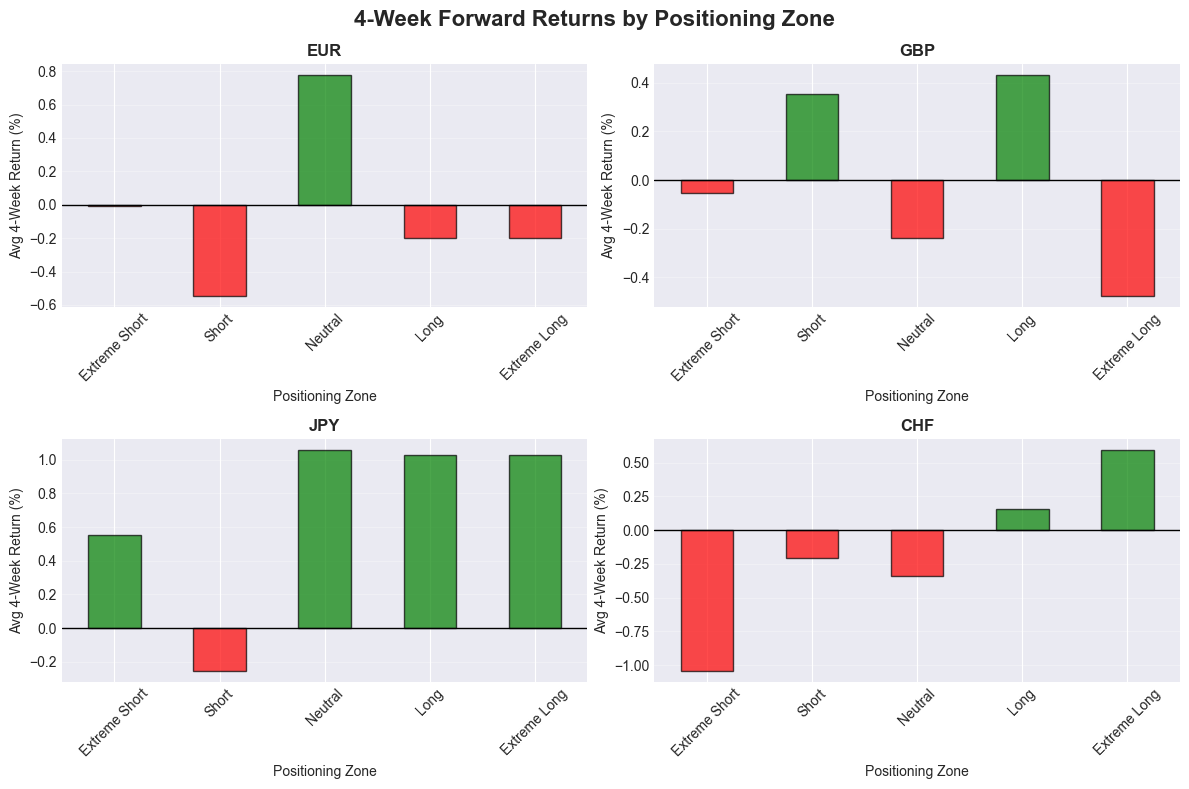

✓ Positioning zone analysis visualization complete


In [15]:
# Visualization: Returns by positioning zones
if price_data and len(df_analysis) > 0:
    fig, axes = plt.subplots(2, 2, figsize=FIGSIZE_SQUARE)
    fig.suptitle('4-Week Forward Returns by Positioning Zone', fontsize=16, fontweight='bold')

    for idx, currency in enumerate(['EUR', 'GBP', 'JPY', 'CHF']):
        if currency not in df_analysis['currency'].unique():
            continue

        ax = axes[idx // 2, idx % 2]
        df_curr = df_analysis[df_analysis['currency'] == currency]

        # Calculate mean returns by zone
        zone_returns = df_curr.groupby('position_zone')['return_4w'].mean()

        # Bar plot
        colors = ['green' if x > 0 else 'red' for x in zone_returns.values]
        zone_returns.plot(kind='bar', ax=ax, color=colors, alpha=0.7, edgecolor='black')

        ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax.set_xlabel('Positioning Zone', fontsize=10)
        ax.set_ylabel('Avg 4-Week Return (%)', fontsize=10)
        ax.set_title(f"{currency}", fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print("✓ Positioning zone analysis visualization complete")

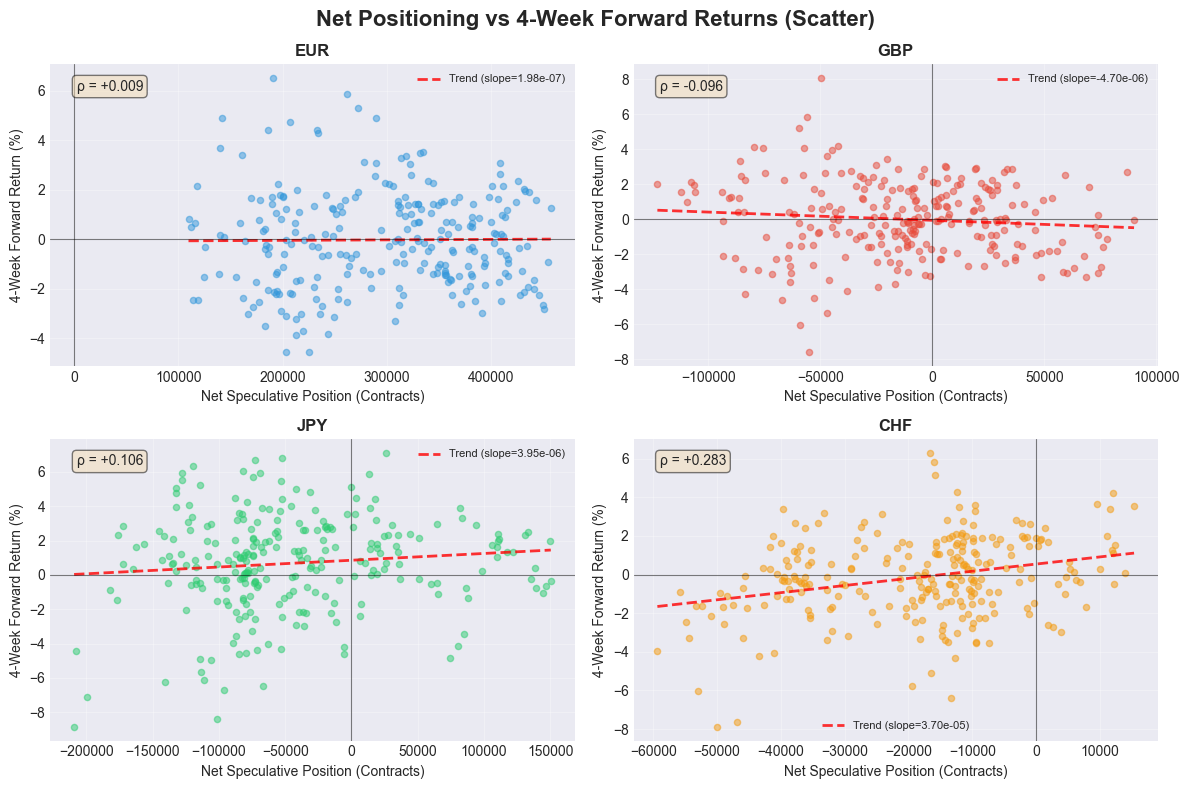

✓ Scatter plot visualization complete


In [17]:
# Scatter plots: Positioning vs Forward Returns
if price_data and len(df_analysis) > 0:
    fig, axes = plt.subplots(2, 2, figsize=FIGSIZE_SQUARE)
    fig.suptitle('Net Positioning vs 4-Week Forward Returns (Scatter)', fontsize=16, fontweight='bold')

    for idx, currency in enumerate(['EUR', 'GBP', 'JPY', 'CHF']):
        if currency not in df_analysis['currency'].unique():
            continue

        ax = axes[idx // 2, idx % 2]
        df_curr = df_analysis[df_analysis['currency'] == currency].copy()

        # Drop rows where either column has NaN (aligned drop)
        df_plot = df_curr[['spec_net', 'return_4w']].dropna()

        # Scatter plot
        ax.scatter(df_plot['spec_net'], df_plot['return_4w'],
                   alpha=0.5, color=CURRENCY_INFO[currency]['color'], s=20)

        # Add trend line
        z = np.polyfit(df_plot['spec_net'], df_plot['return_4w'], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(df_plot['spec_net'].min(), df_plot['spec_net'].max(), 100)
        ax.plot(x_trend, p(x_trend), "r--", linewidth=2, alpha=0.8, label=f'Trend (slope={z[0]:.2e})')

        # Reference lines
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

        # Correlation
        corr = df_plot['spec_net'].corr(df_plot['return_4w'])
        ax.text(0.05, 0.95, f'ρ = {corr:+.3f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ax.set_xlabel('Net Speculative Position (Contracts)', fontsize=10)
        ax.set_ylabel('4-Week Forward Return (%)', fontsize=10)
        ax.set_title(f"{currency}", fontsize=12, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✓ Scatter plot visualization complete")

### Scatter Plot Interpretation — Signal Clarity

The scatter plots confirm the statistical results visually:

**EUR** — A near-flat trend line (slope ≈ 0) and a cloud of points evenly distributed above and below zero across all positioning levels. There is no visual structure. The signal is noise.

**GBP** — A slight downward slope: higher positioning tends to correlate with lower returns. The cloud is noisy but the downward trend line is more visible than EUR, consistent with the weak contrarian signal we found statistically.

**JPY** — An upward slope. More short positioning → negative correlation with USDJPY returns means… JPY shorts preceded JPY weakness (USDJPY rises), which is momentum not mean-reversion. This chart captures the 2021–2024 yen carry trade regime perfectly.

**CHF** — The steepest positive slope (ρ = +0.283), with a clearly visible upward trend. CHF long positioning predicted positive CHF returns (USDCHF falling). The scatter is wider but directionally clear.

---

**Overall Assessment**: COT positioning has genuine but currency-specific predictive content. It should not be applied as a universal contrarian rule. The Sentiment Agent should implement:
- A **long/short contrarian signal** for GBP
- A **risk-off momentum signal** for CHF (longs = buy CHF)
- A **macro-regime signal** for JPY (requires regime identification layer)
- No standalone COT signal for EUR in normal conditions

## 5. Conclusions

Having collected 5 years of institutional positioning data, validated its quality, explored its structure, and tested it against actual price returns, we can now summarize what the data tells us — and what it doesn't.

### What We Found

**1. The Data is Excellent**
261 weekly reports per currency, no gaps, no outliers, no missing values. CFTC data is regulatory-grade and lives up to it. No preprocessing decisions were required — we used the data as-is.

**2. Each Currency Has a Positioning Personality**
- **EUR**: Structurally long. Institutions didn't oscillate; they maintained bullish EUR exposure throughout 2021–2025, only reducing it during the 2022 dollar surge
- **GBP**: Genuinely mean-reverting. Positioning swung from extreme short (2022 UK mini-budget crisis) to extreme long (2023 recovery) and back. The most responsive to fundamental shocks
- **JPY**: A tale of two regimes. A 4-year short position (BOJ at zero, yield differential trade) followed by an explosive reversal when the BOJ pivoted in 2024. Bimodal distribution is the statistical fingerprint of this regime shift
- **CHF**: Persistently net short, reflecting the structural Swiss franc overvaluation hedge. Rare long events coincide with geopolitical or financial stress episodes

**3. The Contrarian Hypothesis: Nuanced, Not Universal**

| Currency | Correlation (4W) | Signal Type | Usable? |
|---|---|---|---|
| EUR | ρ ≈ +0.009 | None | ❌ |
| GBP | ρ ≈ −0.096 | Weak contrarian | ✅ Confirming |
| JPY | ρ ≈ +0.106 | Momentum (regime) | ✅ With regime filter |
| CHF | ρ ≈ +0.283 | Momentum (risk-off) | ✅ Risk-off indicator |

The popular idea that "COT extremes = contrarian signal" does not hold universally. For GBP it does, weakly. For JPY and CHF, positioning follows through — it's a momentum/conviction indicator, not a fade signal. Context determines the interpretation.

**4. The JPY Story is the Most Valuable Insight**
The 2024 JPY squeeze — from −200k to +150k contracts in under 12 months — was the most crowded positioning event in FX markets during this period. The fact that it *did* reverse catastrophically after reaching extreme short levels proves the contrarian principle was operating, just on a longer time horizon than 4 weeks. This suggests the signal lag for structural macro positions is measured in months, not weeks.

---

### Implications for the Sentiment Agent

The COT data should be incorporated as **three distinct features**, not one:

1. **`COT_CONTRARIAN_SCORE`** — primarily for GBP; high = crowded, likely to mean-revert
2. **`COT_RISKOFF_INDICATOR`** — CHF long positioning as a risk sentiment gauge
3. **`COT_REGIME_SHIFT_ALERT`** — JPY positioning change velocity (rate of change from extreme) as an early warning of macro regime inflection

**Lag consideration**: COT data has a 3-day publication lag (Tuesday cutoff, Friday release). Models consuming this data must apply a minimum 3-day forward offset to avoid lookahead bias.

## 6. Export to Silver Layer

The analysis is complete. We now export the cleaned, feature-engineered COT data to `data/processed/macro/` following the project's Silver Macro schema.

Each currency gets its own file containing the weekly net speculative positioning series. The `series_id` naming convention (`COT_EUR_NET`, etc.) makes the data self-describing when loaded by the Sentiment Agent without needing external metadata.

**Schema**: `[timestamp_utc, series_id, value, source, frequency, units]`
- `value`: Net speculative contracts (Asset Mgr + Lev Money, Long minus Short)
- `frequency`: `W` (weekly, Tuesday cutoff)
- `source`: `cftc`
- `units`: `Contracts`
- `timestamp_utc`: ISO 8601 with UTC timezone

In [18]:
def export_to_silver(df_cot, output_dir: Path) -> dict[str, Path]:
    """
    Export COT positioning data to Silver layer following macro schema.

    Schema: [timestamp_utc, series_id, value, source, frequency, units]

    Args:
        df_cot: DataFrame with columns ['report_date', 'currency', 'spec_net', ...]
        output_dir: Path to data/processed/macro/

    Returns:
        Dictionary mapping series_id to exported file path
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    exported = {}

    # Get date range for filename
    start_date = df_cot['report_date'].min().strftime('%Y-%m-%d')
    end_date = df_cot['report_date'].max().strftime('%Y-%m-%d')

    for currency in ['EUR', 'GBP', 'JPY', 'CHF']:
        series_id = f"COT_{currency}_NET"

        # Filter data for this currency
        df_curr = df_cot[df_cot['currency'] == currency].copy()

        # Transform to Silver schema
        df_silver = pd.DataFrame({
            'timestamp_utc': df_curr['report_date'].dt.tz_localize('UTC').dt.strftime('%Y-%m-%dT%H:%M:%SZ'),
            'series_id': series_id,
            'value': df_curr['spec_net'],  # Net speculative positioning
            'source': 'cftc',
            'frequency': 'W',  # Weekly
            'units': 'Contracts'
        })

        # Export
        filename = f"macro_{series_id}_{start_date}_{end_date}.csv"
        filepath = output_dir / filename
        df_silver.to_csv(filepath, index=False)
        exported[series_id] = filepath

        print(f"✓ Exported {series_id}: {len(df_silver)} records → {filename}")

    return exported

# Execute export
silver_dir = Path('data') / 'processed' / 'macro'
exported = export_to_silver(df_cot, silver_dir)

print(f"\n✓ All COT data exported to {silver_dir}")
print("✓ Files ready for Sentiment Agent consumption")

✓ Exported COT_EUR_NET: 261 records → macro_COT_EUR_NET_2021-01-05_2025-12-30.csv
✓ Exported COT_GBP_NET: 261 records → macro_COT_GBP_NET_2021-01-05_2025-12-30.csv
✓ Exported COT_JPY_NET: 261 records → macro_COT_JPY_NET_2021-01-05_2025-12-30.csv
✓ Exported COT_CHF_NET: 261 records → macro_COT_CHF_NET_2021-01-05_2025-12-30.csv

✓ All COT data exported to data\processed\macro
✓ Files ready for Sentiment Agent consumption


In [19]:
# Verify exported files
print("\n" + "=" * 80)
print("VERIFICATION: Silver Layer Schema Compliance")
print("=" * 80)

for series_id, path in exported.items():
    print(f"\n{series_id}:")
    df_verify = pd.read_csv(path)

    # Schema check
    expected_columns = ['timestamp_utc', 'series_id', 'value', 'source', 'frequency', 'units']
    actual_columns = df_verify.columns.tolist()

    if actual_columns == expected_columns:
        print("  ✓ Schema compliant")
    else:
        print(f"  ✗ Schema mismatch: {actual_columns}")

    # Sample data
    print(f"  Records: {len(df_verify)}")
    print(f"  Date range: {df_verify['timestamp_utc'].min()} to {df_verify['timestamp_utc'].max()}")
    print(f"  Value range: {df_verify['value'].min():,.0f} to {df_verify['value'].max():,.0f}")
    print("\n  Sample rows:")
    print(df_verify.head(3).to_string(index=False))

print("\n" + "=" * 80)
print("✓ All files verified and ready for use by Sentiment Agent")
print("=" * 80)


VERIFICATION: Silver Layer Schema Compliance

COT_EUR_NET:
  ✓ Schema compliant
  Records: 261
  Date range: 2021-01-05T00:00:00Z to 2025-12-30T00:00:00Z
  Value range: 109,675 to 457,053

  Sample rows:
       timestamp_utc   series_id  value source frequency     units
2021-01-05T00:00:00Z COT_EUR_NET 343861   cftc         W Contracts
2021-01-12T00:00:00Z COT_EUR_NET 351492   cftc         W Contracts
2021-01-19T00:00:00Z COT_EUR_NET 362353   cftc         W Contracts

COT_GBP_NET:
  ✓ Schema compliant
  Records: 261
  Date range: 2021-01-05T00:00:00Z to 2025-12-30T00:00:00Z
  Value range: -122,766 to 89,989

  Sample rows:
       timestamp_utc   series_id  value source frequency     units
2021-01-05T00:00:00Z COT_GBP_NET   3631   cftc         W Contracts
2021-01-12T00:00:00Z COT_GBP_NET  12478   cftc         W Contracts
2021-01-19T00:00:00Z COT_GBP_NET  12818   cftc         W Contracts

COT_JPY_NET:
  ✓ Schema compliant
  Records: 261
  Date range: 2021-01-05T00:00:00Z to 2025-12-30T0

---

## Summary

This notebook answered the question: *does crowded institutional positioning predict reversals?*

The answer: **yes for GBP, momentum for CHF and JPY, absent for EUR** — over the 2021–2025 period.

The JPY positioning story was the most striking finding: the build-up of a 200k-contract net short through 2021–2024 (betting indefinitely on BOJ inaction) represented one of the most concentrated trades in modern FX history, and its eventual unwind in 2024 was violent. Even though the 4-week correlation was positive (momentum), the full cycle confirmed the contrarian principle operating on a macro timescale.

**Outputs**:
- `data/processed/macro/macro_COT_EUR_NET_2021-01-05_2025-12-30.csv` — 261 records
- `data/processed/macro/macro_COT_GBP_NET_2021-01-05_2025-12-30.csv` — 261 records
- `data/processed/macro/macro_COT_JPY_NET_2021-01-05_2025-12-30.csv` — 261 records
- `data/processed/macro/macro_COT_CHF_NET_2021-01-05_2025-12-30.csv` — 261 records

All files are schema-compliant and ready for Sentiment Agent integration.

---
*FX-AlphaLab · W6 Data Understanding Deliverable*

---

## Glossary of Technical Terms

### Market Structure

**CFTC** — Commodity Futures Trading Commission. The US regulator that oversees futures markets and mandates large traders report their positions weekly.

**COT (Commitments of Traders)** — The weekly report the CFTC publishes summarizing how different categories of market participants are positioned across all futures markets.

**FX Futures** — Contracts traded on the CME exchange to buy or sell a currency at a fixed price on a future date. CME EUR futures represent a standardized €125,000 lot quoted in USD. These are separate from the spot FX market but highly correlated.

**Commodity Code** — The CFTC's internal identifier for each futures contract (EUR = 099741, GBP = 096742, JPY = 097741, CHF = 092741). Used to filter the relevant rows from the raw file, which contains all commodity markets (oil, grains, equities, FX, etc.)

**Open Interest** — The total number of outstanding (unsettled) futures contracts at any point in time. We divide net positioning by open interest to normalize across currencies with different contract sizes — e.g., EUR futures notional is far larger than CHF.

**Long / Short** — A long position profits if price rises. A short position profits if price falls. In EUR futures, being long = expecting EUR to appreciate against USD.

**Net Position** — Longs minus Shorts for a given group. A net +150,000 means that group holds 150k more long contracts than short contracts.

---

### Market Participant Categories

**Asset Managers** — Pension funds, mutual funds, insurance companies. Long-term, slow-moving institutional investors. Their FX positioning is often a byproduct of equity/bond holdings (e.g., holding European stocks means holding EUR as a side effect).

**Leveraged Money** — Hedge funds, CTAs, and proprietary trading firms. The fast-money tactical speculators — they move quickly, respond to momentum and macro signals, and actively trade for profit.

**CTA (Commodity Trading Adviser)** — A type of hedge fund that trades primarily futures (commodities, FX, rates) using systematic/algorithmic strategies, often trend-following.

**Dealer / Intermediary** — Banks and prime brokers acting as market-makers. Their positioning is not directional speculation — it's driven by what their clients do. Excluded from our speculative signal.

**Non-Reportable** — Traders below the CFTC's reporting threshold (retail speculators, small accounts). Treated as noise.

**Speculative Net Positioning** — In this notebook: `(Asset Mgr Long + Lev Money Long) − (Asset Mgr Short + Lev Money Short)`. Combines the two profit-seeking groups into a single number measuring how much institutional money is betting on a currency's direction.

---

### Trading Concepts

**Contrarian Signal** — When positioning reaches an extreme (everyone on one side), the trade is "crowded" and prone to reversal. When everyone who wants to buy has already bought, there are no more buyers — price can only fall.

**Momentum Signal** — The opposite of contrarian. Positioning continues in the direction of a strong fundamental driver. JPY in 2021–2024 was a momentum regime: everyone was short because the BOJ kept rates at zero, and being short kept working.

**Carry Trade** — Borrowing in a low-interest-rate currency (JPY, CHF) to invest in a high-interest-rate currency (USD, AUD), earning the interest rate differential. Creates structural short positioning in JPY and CHF as traders sell them to fund higher-yielding positions.

**Safe Haven** — Currencies that investors buy during crises: JPY, CHF, USD. CHF long flows typically represent genuine stress demand events, which tend to persist rather than reverse — making them momentum signals, not contrarian.

**Rate Differential** — The difference in interest rates between two countries. The primary FX driver in 2022–2025: the Fed hiked rates to ~5.25%, driving massive USD strength and structural short positioning in EUR, GBP, JPY, and CHF.

**BOJ (Bank of Japan)** — Japan's central bank. Kept interest rates pinned near zero for decades via Yield Curve Control, making JPY the world's cheapest funding currency and a perpetual carry-trade short. The 2024 pivot (first rate hike in 17 years) triggered a violent short squeeze.

**Short Squeeze** — When a heavily shorted asset rises, forcing short-sellers to buy back (cover) their positions, which itself accelerates the price rise. JPY in 2024 was the textbook case: a −200k contract short position unwound within months.

**Crowding** — When too many institutional traders are in the same trade. Creates fragility: any negative surprise causes everyone to exit simultaneously, amplifying the move.

---

### Statistical & Data Terms

**Percentile Rank** — Where a given value sits relative to the distribution of all historical values. The 90th percentile means positioning is more extreme than 90% of all past observations. Used to define position zones without making distributional assumptions.

**Position Zone** — The five categorical buckets from the percentile rank: Extreme Short (0–20th percentile), Short (20–40th), Neutral (40–60th), Long (60–80th), Extreme Long (80–100th).

**Forward Return** — The price return *after* a given observation. A 4-week forward return measures how much the price moved in the 4 weeks following each COT report — the target variable we're trying to predict.

**Correlation (ρ, rho)** — A number from −1 to +1 measuring linear relationship strength. ρ = +1 means perfectly positive, ρ = −1 perfectly inverse, ρ ≈ 0 means no linear relationship. EUR had ρ ≈ +0.009 (no signal), CHF had ρ ≈ +0.283 (moderate momentum signal).

**Z-Score** — How many standard deviations a value is from the mean. A z-score above 3 indicates a statistically rare event (0.3% probability under a normal distribution). Used here to detect data entry errors in the quality assessment.

**Standard Deviation** — A measure of how spread out values are from the mean. The ±1 std dev band on the time series charts marks "historically elevated" positioning levels.

**Bimodal Distribution** — A histogram with two distinct peaks rather than one. JPY's distribution is bimodal because the data spans two separate regimes: the 2021–2023 deep-short era and the 2024–2025 near-zero/long era. Treating bimodal data as one normal distribution misleads any signal built on top of it.

**np.polyfit / Trend Line** — `numpy.polyfit` fits a least-squares polynomial (degree 1 = straight line) through x/y data. Used in scatter plots to visualize the directional relationship between positioning and returns.

**merge_asof** — A pandas function for nearest-match date merges. Instead of requiring exact date matches, it finds the nearest record within a tolerance window. Used because COT report dates (Tuesday cutoffs) don't align exactly with weekly OHLCV closes (Fridays).

---

### Data Architecture Terms

**OHLCV** — Open, High, Low, Close, Volume. The standard candlestick data format. Each row represents one time period (daily bar, hourly bar, etc.).

**Silver Layer** — In the Medallion data architecture used in this project, Silver is the "processed" layer: cleaned, validated, normalized to a standard schema, and ready for analysis. Contrasts with Bronze (raw immutable source data) and Gold (business-ready outputs like signals and reports).

**Parquet** — A column-oriented binary file format optimized for analytical queries. More efficient than CSV for large datasets because it stores data by column and supports compression.

**Schema** — The defined structure of a dataset: column names, data types, and semantics. The Silver macro schema is `[timestamp_utc, series_id, value, source, frequency, units]`.

---

### Macro Regime Terms

**Reflation** — The recovery phase after a deflationary shock (here: post-COVID 2021). Characterized by rising inflation expectations, risk-on behavior, and USD weakness, which drove EUR and GBP positioning higher.

**Fed Hiking Cycle** — The 2022–2023 period when the US Federal Reserve raised interest rates from 0% to ~5.25% to fight inflation — the fastest hiking cycle in 40 years. The primary force behind EUR and GBP positioning collapses in 2022.

**Yield Curve Control (YCC)** — BOJ policy of capping the 10-year Japanese government bond yield by purchasing unlimited quantities. Kept Japanese rates artificially near zero for years — the fundamental reason why JPY was the world's default short from 2021 to 2024.

---
*FX-AlphaLab · W6 Glossary*